# Brent Oil Price Analysis: Exploratory Data Analysis

## Overview
This notebook performs comprehensive exploratory data analysis (EDA) on Brent oil prices from 1987-2022, examining price trends, volatility patterns, and potential correlations with major geopolitical events.

**Key Objectives:**
1. Understand price trends and patterns over 35+ years
2. Identify periods of high volatility and structural breaks  
3. Examine seasonal effects and cyclical patterns
4. Visualize major geopolitical events and their timing relative to price movements
5. Establish foundation for change point detection and causal analysis

**Important Note:** This analysis identifies statistical correlations and patterns. Any relationships found between events and price movements should be interpreted as correlational, not causal, due to multiple confounding factors in oil markets.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import ruptures as rpt

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Libraries imported successfully!
Pandas version: 2.3.1
NumPy version: 2.3.2
Matplotlib version: 3.10.5


## 1. Data Loading and Initial Exploration

Let's start by loading the Brent oil price data and performing initial inspection.

In [2]:
# Load the Brent oil price data
data_path = '../data/BrentOilPrices.csv'
df = pd.read_csv(data_path)

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumn Names:", df.columns.tolist())
print("\nData Types:")
print(df.dtypes)
print("\nFirst 5 rows:")
print(df.head())
print("\nLast 5 rows:")
print(df.tail())

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

# Basic statistical summary
print(f"\nBasic Statistics:")
print(df.describe())

Dataset Shape: (9011, 2)

Column Names: ['Date', 'Price']

Data Types:
Date      object
Price    float64
dtype: object

First 5 rows:
        Date  Price
0  20-May-87  18.63
1  21-May-87  18.45
2  22-May-87  18.55
3  25-May-87  18.60
4  26-May-87  18.63

Last 5 rows:
              Date  Price
9006  Nov 08, 2022  96.85
9007  Nov 09, 2022  93.05
9008  Nov 10, 2022  94.25
9009  Nov 11, 2022  96.37
9010  Nov 14, 2022  93.59

Missing values:
Date     0
Price    0
dtype: int64

Basic Statistics:
             Price
count  9011.000000
mean     48.420782
std      32.860110
min       9.100000
25%      19.050000
50%      38.570000
75%      70.090000
max     143.950000


## 2. Data Preprocessing and Cleaning

Now let's clean and prepare the data for analysis.

In [3]:
# Data preprocessing
def preprocess_data(df):
    """
    Clean and preprocess the Brent oil price data
    """
    # Make a copy to avoid modifying the original
    df_clean = df.copy()
    
    # Convert Date column to datetime
    df_clean['Date'] = pd.to_datetime(df_clean['Date'], errors='coerce')
    
    # Sort by date
    df_clean = df_clean.sort_values('Date').reset_index(drop=True)
    
    # Create additional time-based features
    df_clean['Year'] = df_clean['Date'].dt.year
    df_clean['Month'] = df_clean['Date'].dt.month
    df_clean['Day'] = df_clean['Date'].dt.day
    df_clean['DayOfWeek'] = df_clean['Date'].dt.dayofweek
    df_clean['DayOfYear'] = df_clean['Date'].dt.dayofyear
    df_clean['Quarter'] = df_clean['Date'].dt.quarter
    
    # Calculate price changes
    df_clean['Price_Change'] = df_clean['Price'].diff()
    df_clean['Price_Pct_Change'] = df_clean['Price'].pct_change() * 100
    df_clean['Log_Price'] = np.log(df_clean['Price'])
    df_clean['Log_Return'] = df_clean['Log_Price'].diff()
    
    # Calculate rolling statistics
    df_clean['MA_30'] = df_clean['Price'].rolling(window=30).mean()
    df_clean['MA_90'] = df_clean['Price'].rolling(window=90).mean()
    df_clean['MA_365'] = df_clean['Price'].rolling(window=365).mean()
    
    df_clean['Vol_30'] = df_clean['Price_Pct_Change'].rolling(window=30).std()
    df_clean['Vol_90'] = df_clean['Price_Pct_Change'].rolling(window=90).std()
    
    return df_clean

# Apply preprocessing
df_processed = preprocess_data(df)

# Display processed data information
print("Processed Dataset Shape:", df_processed.shape)
print("\nDate range:")
print(f"Start: {df_processed['Date'].min()}")
print(f"End: {df_processed['Date'].max()}")
print(f"Total days: {(df_processed['Date'].max() - df_processed['Date'].min()).days}")

print("\nNew columns created:")
new_cols = [col for col in df_processed.columns if col not in df.columns]
print(new_cols)

print("\nSample of processed data:")
print(df_processed[['Date', 'Price', 'Price_Change', 'Price_Pct_Change', 'MA_30', 'Vol_30']].head(10))

Processed Dataset Shape: (9011, 17)

Date range:
Start: 1987-05-20 00:00:00
End: 2022-11-14 00:00:00
Total days: 12962

New columns created:
['Year', 'Month', 'Day', 'DayOfWeek', 'DayOfYear', 'Quarter', 'Price_Change', 'Price_Pct_Change', 'Log_Price', 'Log_Return', 'MA_30', 'MA_90', 'MA_365', 'Vol_30', 'Vol_90']

Sample of processed data:
        Date  Price  Price_Change  Price_Pct_Change  MA_30  Vol_30
0 1987-05-20  18.63           NaN               NaN    NaN     NaN
1 1987-05-21  18.45         -0.18         -0.966184    NaN     NaN
2 1987-05-22  18.55          0.10          0.542005    NaN     NaN
3 1987-05-25  18.60          0.05          0.269542    NaN     NaN
4 1987-05-26  18.63          0.03          0.161290    NaN     NaN
5 1987-05-27  18.60         -0.03         -0.161031    NaN     NaN
6 1987-05-28  18.60          0.00          0.000000    NaN     NaN
7 1987-05-29  18.58         -0.02         -0.107527    NaN     NaN
8 1987-06-01  18.65          0.07          0.376749    N

In [4]:
# Load geopolitical events data
events_path = '../data/geopolitical_events.csv'
events_df = pd.read_csv(events_path)

# Display events data
print("Events Dataset Shape:", events_df.shape)
print("\nEvents Data:")
print(events_df.head())

# Convert event dates to datetime
events_df['Start_Date'] = pd.to_datetime(events_df['Start_Date'], errors='coerce')

# Filter events that fall within our price data timeframe
price_start = df_processed['Date'].min()
price_end = df_processed['Date'].max()

events_df_filtered = events_df[
    (events_df['Start_Date'] >= price_start) & 
    (events_df['Start_Date'] <= price_end)
].copy()

print(f"\nEvents within price data timeframe: {len(events_df_filtered)}")
print(f"Price data timeframe: {price_start} to {price_end}")

if len(events_df_filtered) > 0:
    print("\nFiltered events:")
    print(events_df_filtered[['Event', 'Start_Date', 'Type']].sort_values('Start_Date'))

Events Dataset Shape: (10, 4)

Events Data:
                             Event  Start_Date  \
0  OPEC+ Market Review and Outlook  2025-07-05   
1                  WOO 2025 Launch  2025-07-10   
2              OPEC+ Market Review  2025-05-31   
3   39th OPEC+ Ministerial Meeting  2025-05-28   
4  OPEC+ Adjusts Production Upward  2025-05-03   

                                         Description                     Type  
0  Eight OPEC+ nations met virtually to reaffirm ...  OPEC+ Production Policy  
1  OPEC launched its World Oil Outlook 2025, proj...         Forecast/Outlook  
2  OPEC+ nations reviewed market conditions and r...       OPEC+ Coordination  
3  Ministerial meeting reaffirmed Declaration of ...           OPEC+ Strategy  
4  OPEC+ countries increased production in respon...      Production Increase  

Events within price data timeframe: 0
Price data timeframe: 1987-05-20 00:00:00 to 2022-11-14 00:00:00


## 3. Exploratory Data Analysis (EDA)

Now let's create comprehensive visualizations to understand the price trends, patterns, and volatility over time.

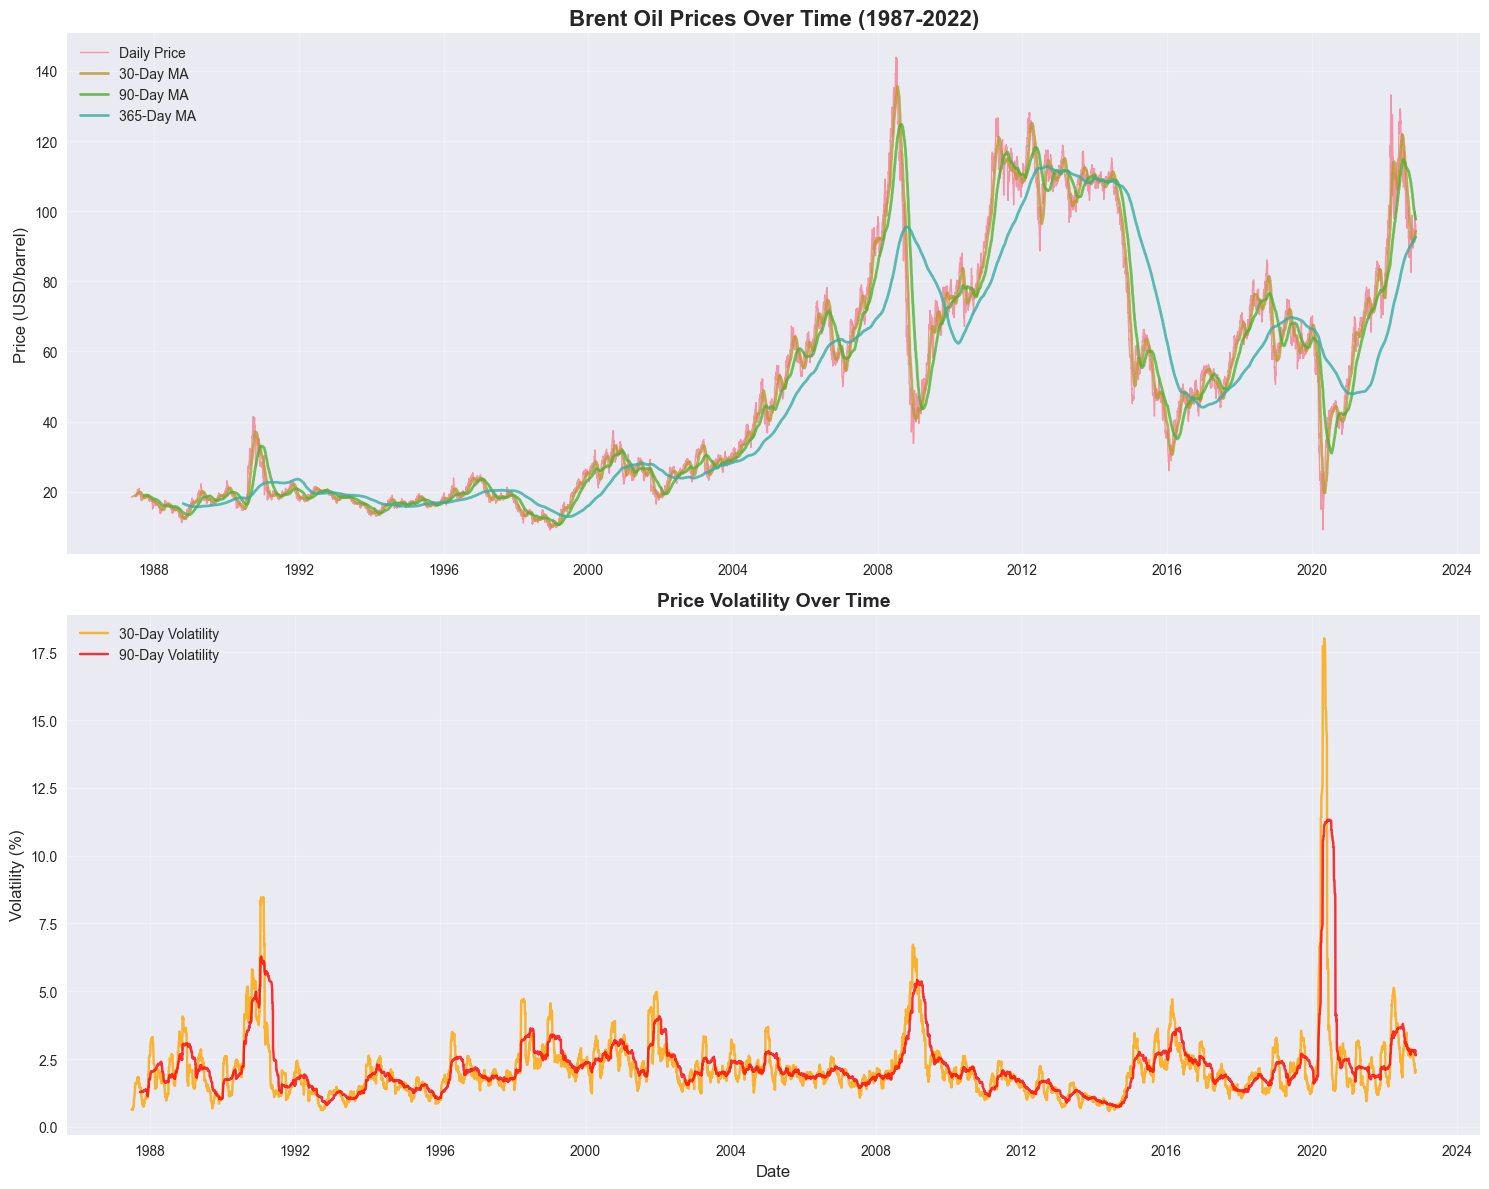

Price Statistics Summary:
Mean Price: $48.42
Median Price: $38.57
Min Price: $9.10 (1998-12-10)
Max Price: $143.95 (2008-07-03)
Standard Deviation: $32.86

Volatility Statistics:
Mean Daily Return: 0.050%
Daily Return Std Dev: 2.525%
Max Daily Gain: 50.99%
Max Daily Loss: -47.47%


In [5]:
# Create comprehensive time series visualizations

# 1. Basic price time series with moving averages
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Main price chart with moving averages
axes[0].plot(df_processed['Date'], df_processed['Price'], alpha=0.7, linewidth=1, label='Daily Price')
axes[0].plot(df_processed['Date'], df_processed['MA_30'], alpha=0.8, linewidth=2, label='30-Day MA')
axes[0].plot(df_processed['Date'], df_processed['MA_90'], alpha=0.8, linewidth=2, label='90-Day MA')
axes[0].plot(df_processed['Date'], df_processed['MA_365'], alpha=0.8, linewidth=2, label='365-Day MA')

axes[0].set_title('Brent Oil Prices Over Time (1987-2022)', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Price (USD/barrel)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add major events as vertical lines if we have events data
if len(events_df_filtered) > 0:
    for _, event in events_df_filtered.iterrows():
        if pd.notna(event['Start_Date']):
            axes[0].axvline(x=event['Start_Date'], color='red', alpha=0.5, linestyle='--', linewidth=1)
            # Add event labels (rotate to avoid overlap)
            axes[0].text(event['Start_Date'], axes[0].get_ylim()[1]*0.9, 
                        event['Event'][:20] + '...', rotation=90, fontsize=8, ha='right')

# Volatility chart
axes[1].plot(df_processed['Date'], df_processed['Vol_30'], alpha=0.8, color='orange', label='30-Day Volatility')
axes[1].plot(df_processed['Date'], df_processed['Vol_90'], alpha=0.8, color='red', label='90-Day Volatility')
axes[1].set_title('Price Volatility Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Volatility (%)', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("Price Statistics Summary:")
print(f"Mean Price: ${df_processed['Price'].mean():.2f}")
print(f"Median Price: ${df_processed['Price'].median():.2f}")
print(f"Min Price: ${df_processed['Price'].min():.2f} ({df_processed.loc[df_processed['Price'].idxmin(), 'Date'].strftime('%Y-%m-%d')})")
print(f"Max Price: ${df_processed['Price'].max():.2f} ({df_processed.loc[df_processed['Price'].idxmax(), 'Date'].strftime('%Y-%m-%d')})")
print(f"Standard Deviation: ${df_processed['Price'].std():.2f}")

print(f"\nVolatility Statistics:")
print(f"Mean Daily Return: {df_processed['Price_Pct_Change'].mean():.3f}%")
print(f"Daily Return Std Dev: {df_processed['Price_Pct_Change'].std():.3f}%")
print(f"Max Daily Gain: {df_processed['Price_Pct_Change'].max():.2f}%")
print(f"Max Daily Loss: {df_processed['Price_Pct_Change'].min():.2f}%")

Available day-of-week values: [0, 1, 2, 3, 4]
Day-of-week averages: DayOfWeek
0   -0.070979
1   -0.042068
2    0.067567
3    0.183834
4    0.105838
Name: Price_Pct_Change, dtype: float64


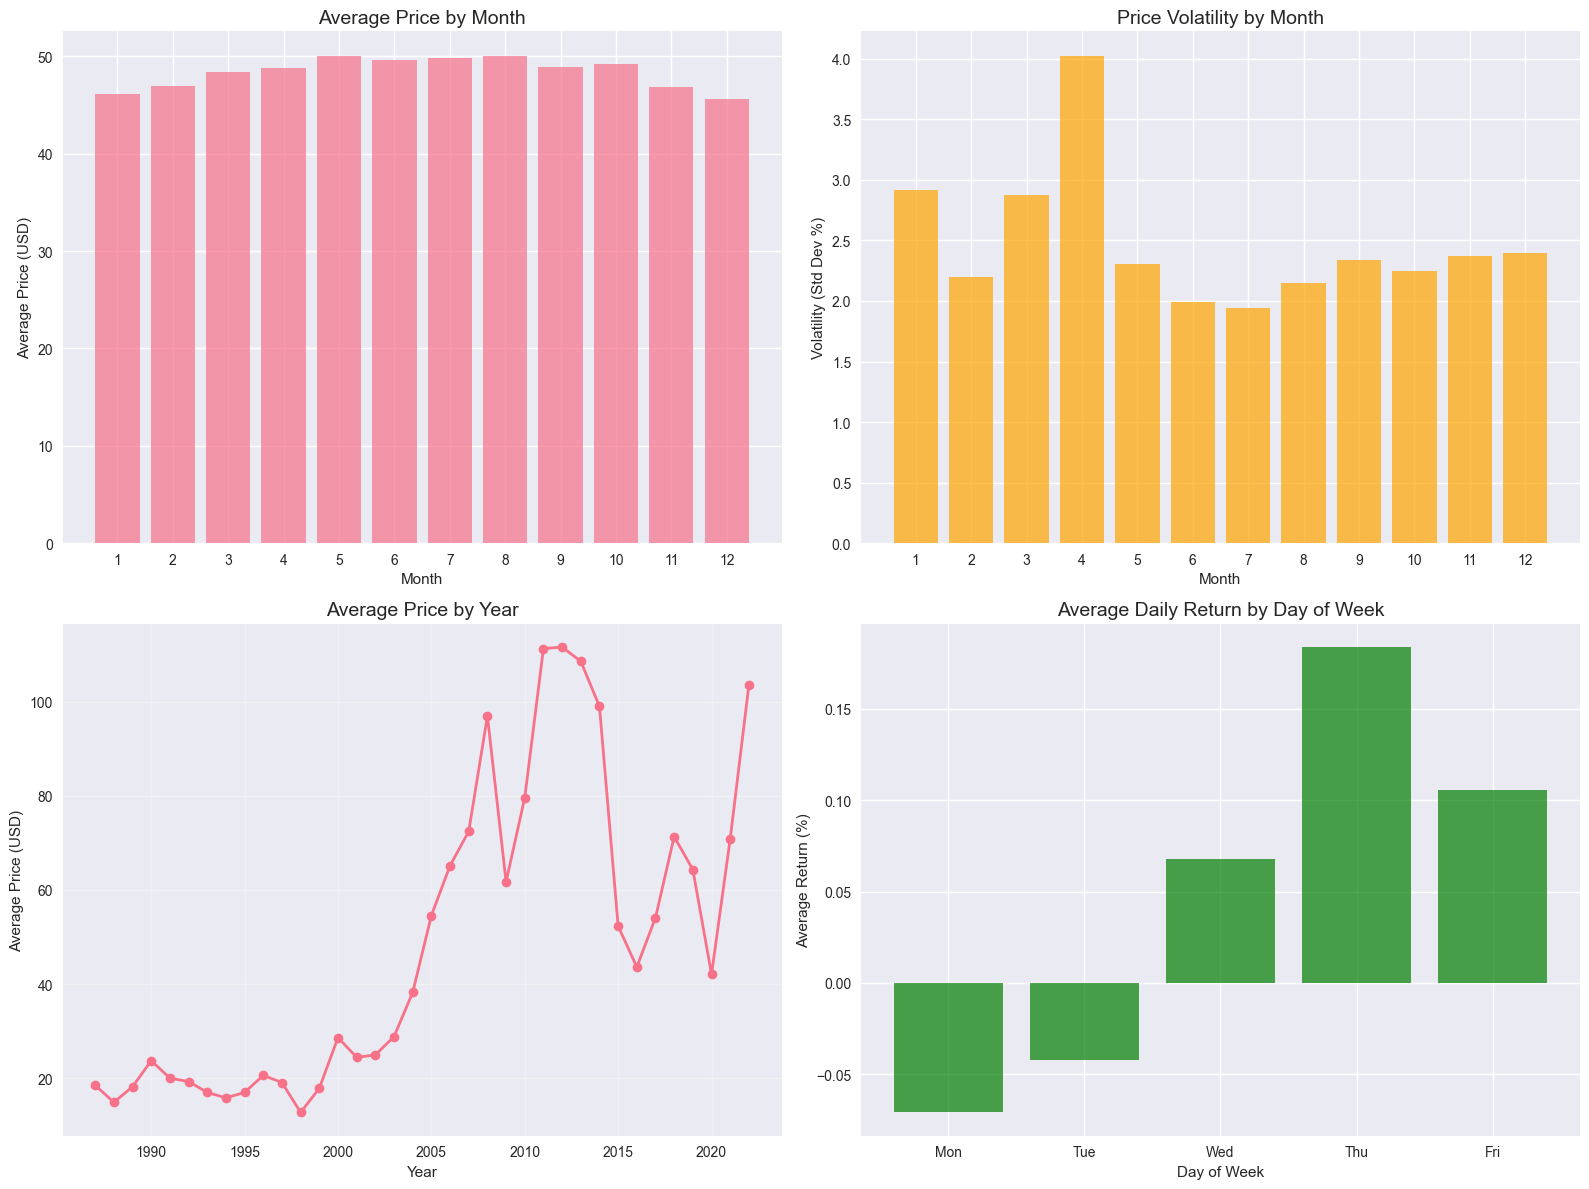

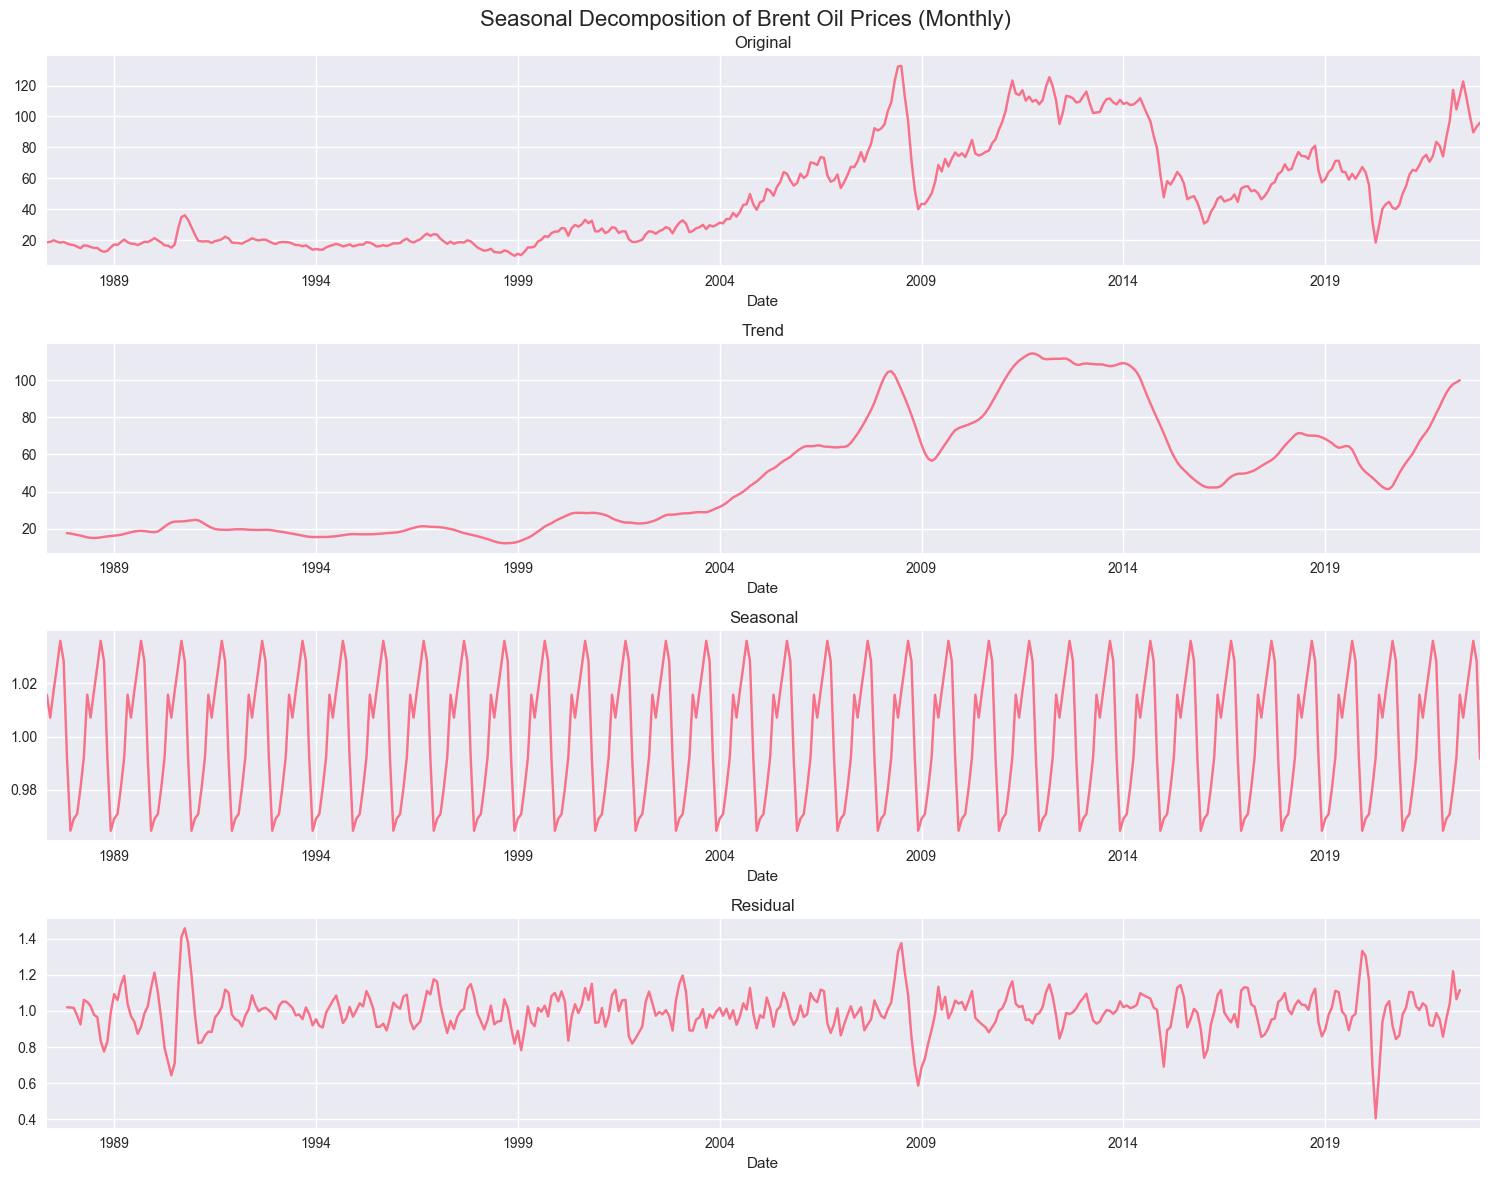

Seasonal Analysis Summary:
Highest average price month: 5 ($50.07)
Lowest average price month: 12 ($45.61)
Most volatile month: 4 (4.03% std dev)
Least volatile month: 7 (1.94% std dev)


In [7]:
# Seasonal and cyclical analysis

# 1. Monthly patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Monthly average prices
monthly_avg = df_processed.groupby('Month')['Price'].mean()
axes[0,0].bar(monthly_avg.index, monthly_avg.values, alpha=0.7)
axes[0,0].set_title('Average Price by Month', fontsize=14)
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Average Price (USD)')
axes[0,0].set_xticks(range(1, 13))

# Monthly volatility
monthly_vol = df_processed.groupby('Month')['Price_Pct_Change'].std()
axes[0,1].bar(monthly_vol.index, monthly_vol.values, alpha=0.7, color='orange')
axes[0,1].set_title('Price Volatility by Month', fontsize=14)
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Volatility (Std Dev %)')
axes[0,1].set_xticks(range(1, 13))

# Yearly average prices
yearly_avg = df_processed.groupby('Year')['Price'].mean()
axes[1,0].plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2)
axes[1,0].set_title('Average Price by Year', fontsize=14)
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Average Price (USD)')
axes[1,0].grid(True, alpha=0.3)

# Day of week patterns - Fix the dimension mismatch
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_avg = df_processed.groupby('DayOfWeek')['Price_Pct_Change'].mean()

# Check what day-of-week values actually exist in the data
print(f"Available day-of-week values: {sorted(dow_avg.index.tolist())}")
print(f"Day-of-week averages: {dow_avg}")

# Create the bar plot using actual data indices and values
axes[1,1].bar(dow_avg.index, dow_avg.values, alpha=0.7, color='green')
axes[1,1].set_title('Average Daily Return by Day of Week', fontsize=14)
axes[1,1].set_xlabel('Day of Week')
axes[1,1].set_ylabel('Average Return (%)')
axes[1,1].set_xticks(dow_avg.index)
# Only label the days that actually exist in the data
existing_day_names = [dow_names[i] for i in dow_avg.index if i < len(dow_names)]
axes[1,1].set_xticklabels(existing_day_names)

plt.tight_layout()
plt.show()

# Seasonal decomposition (using annual data to see long-term patterns)
# Resample to monthly for cleaner decomposition
monthly_data = df_processed.set_index('Date')['Price'].resample('M').mean()

# Perform seasonal decomposition
decomposition = seasonal_decompose(monthly_data, model='multiplicative', period=12)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=axes[0], title='Original')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')

plt.suptitle('Seasonal Decomposition of Brent Oil Prices (Monthly)', fontsize=16)
plt.tight_layout()
plt.show()

print("Seasonal Analysis Summary:")
print(f"Highest average price month: {monthly_avg.idxmax()} (${monthly_avg.max():.2f})")
print(f"Lowest average price month: {monthly_avg.idxmin()} (${monthly_avg.min():.2f})")
print(f"Most volatile month: {monthly_vol.idxmax()} ({monthly_vol.max():.2f}% std dev)")
print(f"Least volatile month: {monthly_vol.idxmin()} ({monthly_vol.min():.2f}% std dev)")

## 4. Time Series Analysis

Let's test for stationarity and examine autocorrelation patterns in the data.

In [8]:
# Stationarity testing
def check_stationarity(timeseries, title):
    """
    Perform ADF and KPSS tests for stationarity
    """
    print(f'\n=== Stationarity Tests for {title} ===')
    
    # Augmented Dickey-Fuller test
    result_adf = adfuller(timeseries.dropna())
    print('ADF Test Results:')
    print(f'ADF Statistic: {result_adf[0]:.6f}')
    print(f'p-value: {result_adf[1]:.6f}')
    print('Critical Values:')
    for key, value in result_adf[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result_adf[1] <= 0.05:
        print("Result: Reject null hypothesis. Data is stationary (ADF test)")
    else:
        print("Result: Fail to reject null hypothesis. Data is non-stationary (ADF test)")
    
    # KPSS test
    result_kpss = kpss(timeseries.dropna(), regression='c')
    print(f'\nKPSS Test Results:')
    print(f'KPSS Statistic: {result_kpss[0]:.6f}')
    print(f'p-value: {result_kpss[1]:.6f}')
    print('Critical Values:')
    for key, value in result_kpss[3].items():
        print(f'\t{key}: {value:.3f}')
    
    if result_kpss[1] <= 0.05:
        print("Result: Reject null hypothesis. Data is non-stationary (KPSS test)")
    else:
        print("Result: Fail to reject null hypothesis. Data is stationary (KPSS test)")

# Test stationarity for price levels
check_stationarity(df_processed['Price'], 'Price Levels')

# Test stationarity for log prices
check_stationarity(df_processed['Log_Price'], 'Log Prices')

# Test stationarity for returns
check_stationarity(df_processed['Price_Pct_Change'], 'Price Returns')

# Test stationarity for log returns
check_stationarity(df_processed['Log_Return'], 'Log Returns')


=== Stationarity Tests for Price Levels ===
ADF Test Results:
ADF Statistic: -1.993856
p-value: 0.289274
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: Fail to reject null hypothesis. Data is non-stationary (ADF test)

KPSS Test Results:
KPSS Statistic: 9.558800
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: Reject null hypothesis. Data is non-stationary (KPSS test)

=== Stationarity Tests for Log Prices ===
ADF Test Results:
ADF Statistic: -1.993856
p-value: 0.289274
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Result: Fail to reject null hypothesis. Data is non-stationary (ADF test)

KPSS Test Results:
KPSS Statistic: 9.558800
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Result: Reject null hypothesis. Data is non-stationary (KPSS test)

=== Stationarity Tests for Log Prices ===
ADF Test Results:
ADF Statistic: -1.808894
p-value: 0.376055
Critical Values:
	1%: -3.431
	5%: -2.862
	

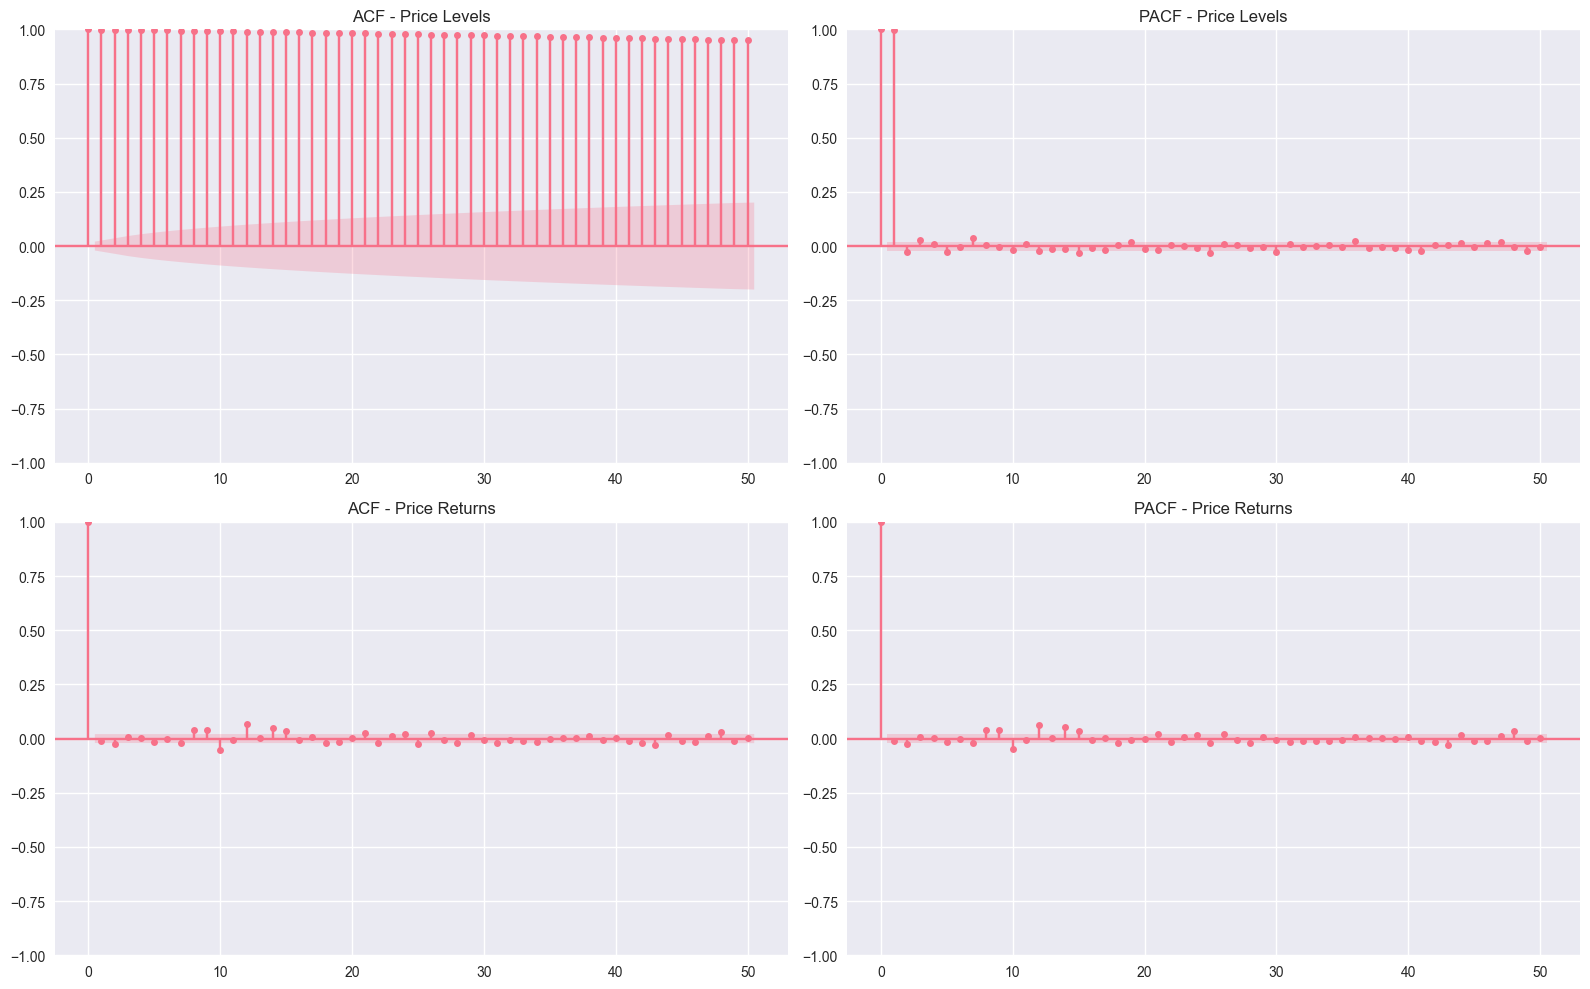

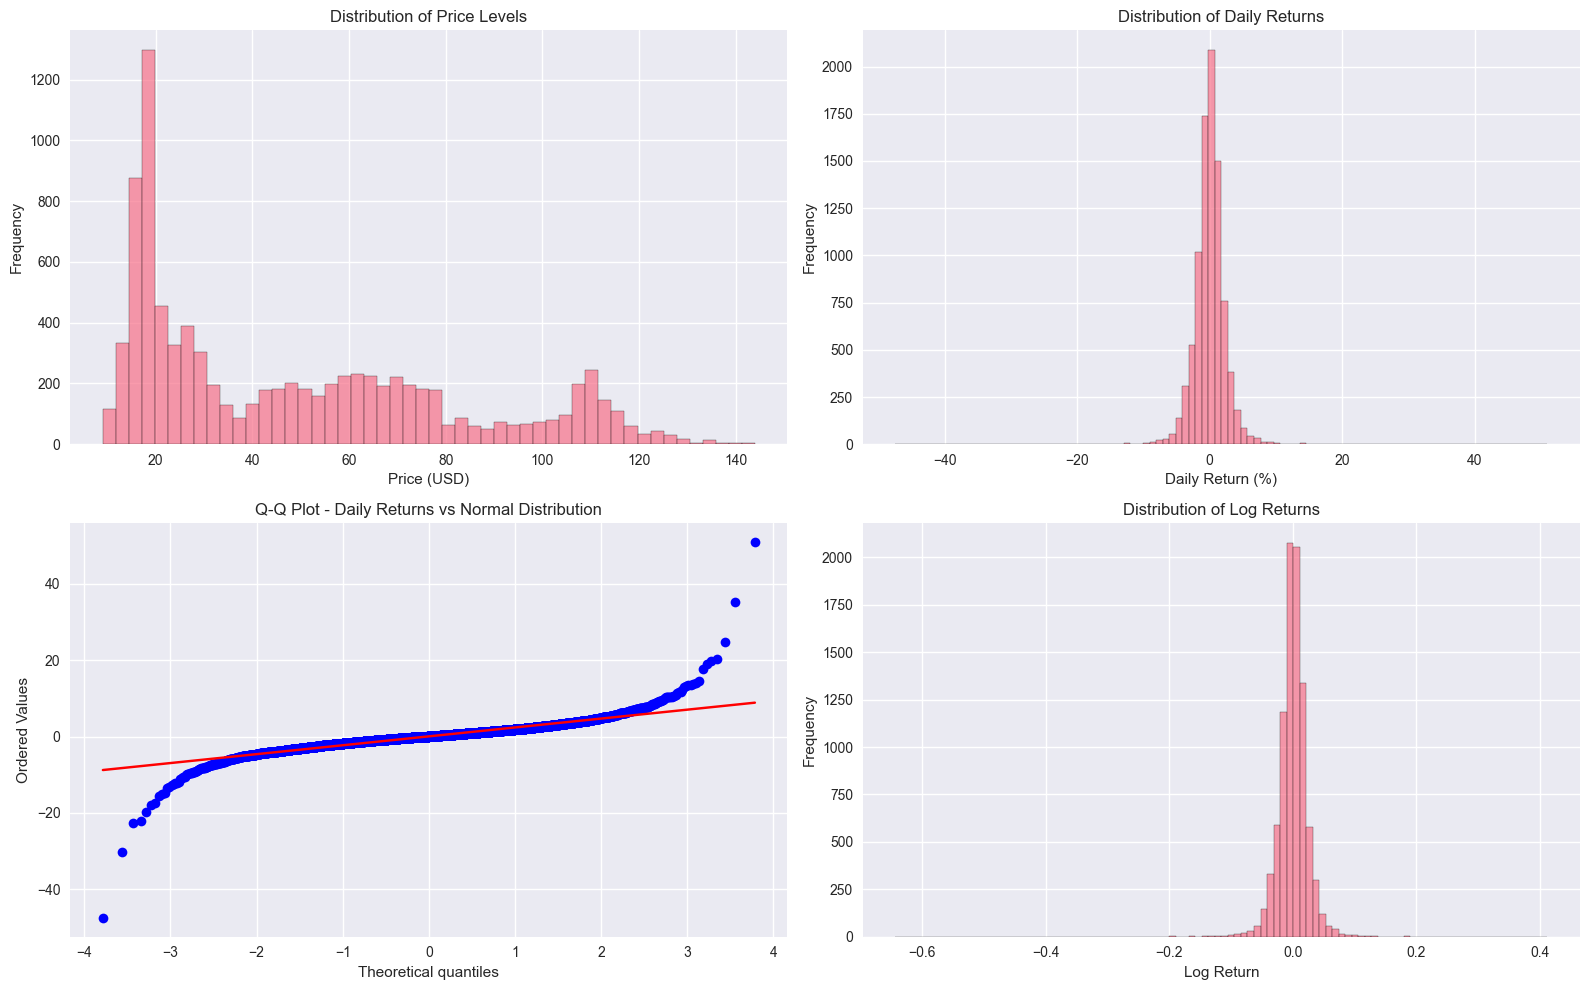

Distribution Statistics for Daily Returns:
Mean: 0.0501%
Std Dev: 2.5255%
Skewness: 0.3116
Kurtosis: 45.4056
Jarque-Bera test p-value: 0.000000

Volatility Analysis:
Ljung-Box test for ARCH effects (p-value at lag 20): 0.000000
Result: Evidence of volatility clustering (ARCH effects)

Additional Volatility Statistics:
Maximum daily loss: -47.47%
Maximum daily gain: 50.99%
99th percentile loss: -6.13%
99th percentile gain: 6.56%
Volatility of volatility (30-day rolling): 1.32%


In [10]:
# ACF and PACF analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ACF and PACF for price levels
plot_acf(df_processed['Price'].dropna(), ax=axes[0,0], lags=50, title='ACF - Price Levels')
plot_pacf(df_processed['Price'].dropna(), ax=axes[0,1], lags=50, title='PACF - Price Levels')

# ACF and PACF for returns
plot_acf(df_processed['Price_Pct_Change'].dropna(), ax=axes[1,0], lags=50, title='ACF - Price Returns')
plot_pacf(df_processed['Price_Pct_Change'].dropna(), ax=axes[1,1], lags=50, title='PACF - Price Returns')

plt.tight_layout()
plt.show()

# Distribution analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Price distribution
axes[0,0].hist(df_processed['Price'], bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribution of Price Levels')
axes[0,0].set_xlabel('Price (USD)')
axes[0,0].set_ylabel('Frequency')

# Returns distribution
axes[0,1].hist(df_processed['Price_Pct_Change'].dropna(), bins=100, alpha=0.7, edgecolor='black')
axes[0,1].set_title('Distribution of Daily Returns')
axes[0,1].set_xlabel('Daily Return (%)')
axes[0,1].set_ylabel('Frequency')

# Q-Q plot for returns
stats.probplot(df_processed['Price_Pct_Change'].dropna(), dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot - Daily Returns vs Normal Distribution')

# Log returns distribution
axes[1,1].hist(df_processed['Log_Return'].dropna(), bins=100, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Distribution of Log Returns')
axes[1,1].set_xlabel('Log Return')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Distribution statistics
returns_clean = df_processed['Price_Pct_Change'].dropna()
print("Distribution Statistics for Daily Returns:")
print(f"Mean: {returns_clean.mean():.4f}%")
print(f"Std Dev: {returns_clean.std():.4f}%") 
print(f"Skewness: {stats.skew(returns_clean):.4f}")
print(f"Kurtosis: {stats.kurtosis(returns_clean):.4f}")
print(f"Jarque-Bera test p-value: {stats.jarque_bera(returns_clean)[1]:.6f}")

# Volatility clustering test (ARCH effects) - Fix the import error
from statsmodels.stats.diagnostic import acorr_ljungbox
print(f"\nVolatility Analysis:")
squared_returns = returns_clean ** 2
ljung_box = acorr_ljungbox(squared_returns, lags=20, return_df=True)
print(f"Ljung-Box test for ARCH effects (p-value at lag 20): {ljung_box['lb_pvalue'].iloc[19]:.6f}")
if ljung_box['lb_pvalue'].iloc[19] < 0.05:
    print("Result: Evidence of volatility clustering (ARCH effects)")
else:
    print("Result: No significant evidence of volatility clustering")

# Additional volatility analysis
print(f"\nAdditional Volatility Statistics:")
print(f"Maximum daily loss: {returns_clean.min():.2f}%")
print(f"Maximum daily gain: {returns_clean.max():.2f}%")
print(f"99th percentile loss: {np.percentile(returns_clean, 1):.2f}%")
print(f"99th percentile gain: {np.percentile(returns_clean, 99):.2f}%")
print(f"Volatility of volatility (30-day rolling): {df_processed['Vol_30'].std():.2f}%")

## 5. Change Point Detection

Now let's identify structural breaks in the time series using multiple change point detection algorithms.

=== PELT Algorithm ===
Number of change points detected (PELT): 7
Change point dates (PELT):
  1999-11-09T00:00:00.000000000 (index 3165)
  2005-02-16T00:00:00.000000000 (index 4515)
  2007-10-17T00:00:00.000000000 (index 5195)
  2008-10-08T00:00:00.000000000 (index 5440)
  2010-12-14T00:00:00.000000000 (index 5990)
  2014-11-03T00:00:00.000000000 (index 6965)
  2021-09-22T00:00:00.000000000 (index 8720)

=== Binary Segmentation Algorithm ===
Number of change points detected (PELT): 7
Change point dates (PELT):
  1999-11-09T00:00:00.000000000 (index 3165)
  2005-02-16T00:00:00.000000000 (index 4515)
  2007-10-17T00:00:00.000000000 (index 5195)
  2008-10-08T00:00:00.000000000 (index 5440)
  2010-12-14T00:00:00.000000000 (index 5990)
  2014-11-03T00:00:00.000000000 (index 6965)
  2021-09-22T00:00:00.000000000 (index 8720)

=== Binary Segmentation Algorithm ===
Number of change points detected (Binary Segmentation): 10
Change point dates (Binary Segmentation):
  1999-11-09T00:00:00.000000

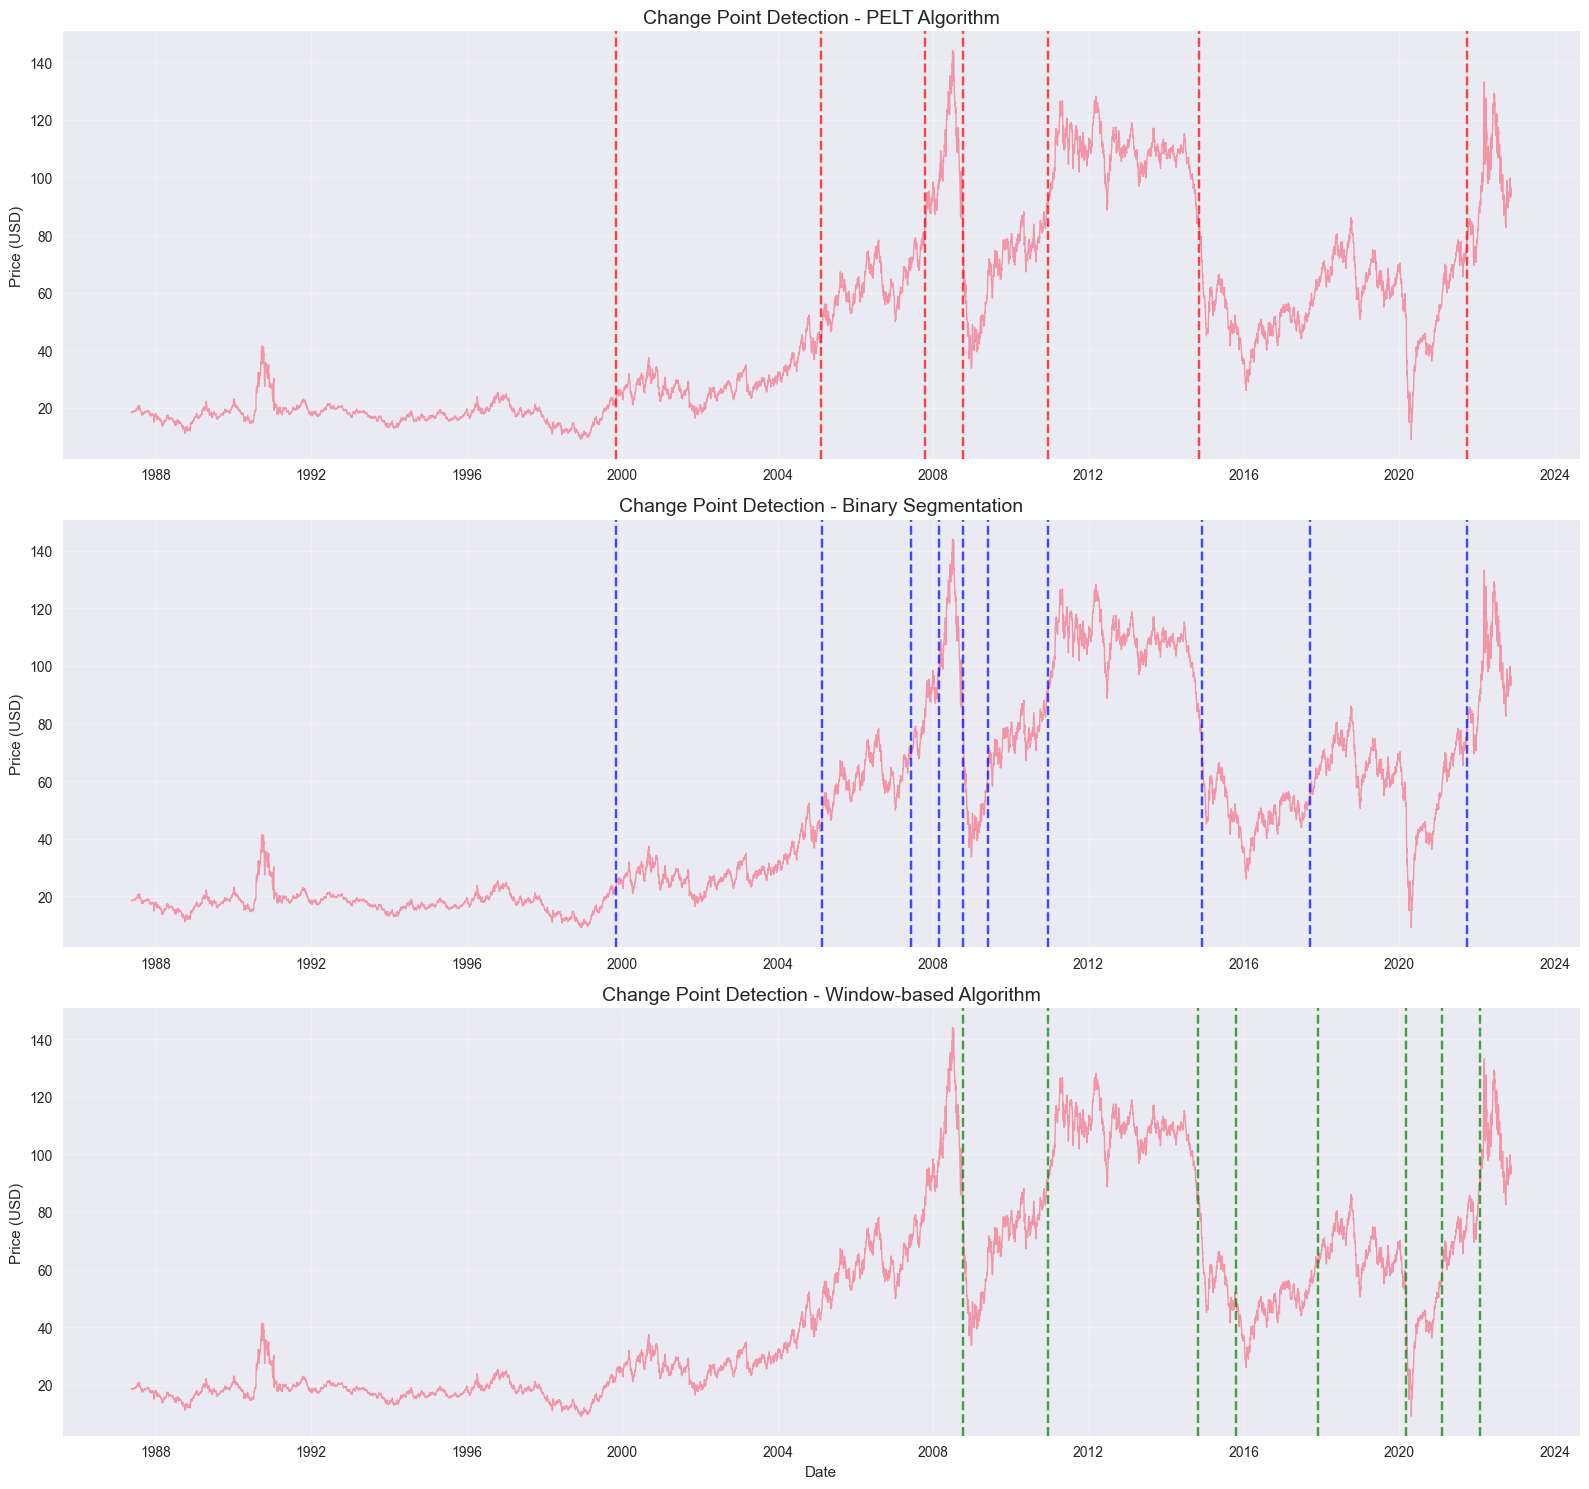


=== All Detected Change Points ===
1999-11-09T00:00:00.000000000 - PELT (Price: $24.44)
1999-11-09T00:00:00.000000000 - BinSeg (Price: $24.44)
2005-02-16T00:00:00.000000000 - PELT (Price: $45.42)
2005-02-23T00:00:00.000000000 - BinSeg (Price: $48.16)
2007-06-04T00:00:00.000000000 - BinSeg (Price: $70.90)
2007-10-17T00:00:00.000000000 - PELT (Price: $85.24)
2008-02-28T00:00:00.000000000 - BinSeg (Price: $99.83)
2008-10-08T00:00:00.000000000 - PELT (Price: $80.77)
2008-10-08T00:00:00.000000000 - BinSeg (Price: $80.77)
2008-10-08T00:00:00.000000000 - Window (Price: $80.77)
2009-05-29T00:00:00.000000000 - BinSeg (Price: $64.98)
2010-12-14T00:00:00.000000000 - PELT (Price: $90.63)
2010-12-14T00:00:00.000000000 - BinSeg (Price: $90.63)
2010-12-21T00:00:00.000000000 - Window (Price: $93.11)
2014-10-27T00:00:00.000000000 - Window (Price: $85.64)
2014-11-03T00:00:00.000000000 - PELT (Price: $84.90)
2014-12-02T00:00:00.000000000 - BinSeg (Price: $71.13)
2015-10-14T00:00:00.000000000 - Window (P

In [11]:
# Change point detection using multiple algorithms

# Prepare data for change point detection
price_data = df_processed['Price'].values
dates = df_processed['Date'].values

# 1. PELT (Pruned Exact Linear Time) algorithm
print("=== PELT Algorithm ===")
algo_pelt = rpt.Pelt(model="rbf").fit(price_data)
result_pelt = algo_pelt.predict(pen=100)  # Penalty parameter - adjust as needed
change_points_pelt = result_pelt[:-1]  # Remove the last point (end of series)

print(f"Number of change points detected (PELT): {len(change_points_pelt)}")
if len(change_points_pelt) > 0:
    print("Change point dates (PELT):")
    for cp in change_points_pelt:
        if cp < len(dates):
            print(f"  {dates[cp]} (index {cp})")

# 2. Binary Segmentation algorithm
print("\n=== Binary Segmentation Algorithm ===")
algo_binseg = rpt.Binseg(model="l2").fit(price_data)
result_binseg = algo_binseg.predict(n_bkps=10)  # Detect up to 10 change points
change_points_binseg = result_binseg[:-1]

print(f"Number of change points detected (Binary Segmentation): {len(change_points_binseg)}")
if len(change_points_binseg) > 0:
    print("Change point dates (Binary Segmentation):")
    for cp in change_points_binseg:
        if cp < len(dates):
            print(f"  {dates[cp]} (index {cp})")

# 3. Window-based change point detection
print("\n=== Window-based Algorithm ===")
algo_window = rpt.Window(width=252, model="l2").fit(price_data)  # 252 trading days ~ 1 year
result_window = algo_window.predict(n_bkps=8)
change_points_window = result_window[:-1]

print(f"Number of change points detected (Window): {len(change_points_window)}")
if len(change_points_window) > 0:
    print("Change point dates (Window):")
    for cp in change_points_window:
        if cp < len(dates):
            print(f"  {dates[cp]} (index {cp})")

# Visualize change points
fig, axes = plt.subplots(3, 1, figsize=(16, 15))

# Plot 1: PELT results
axes[0].plot(dates, price_data, alpha=0.7, linewidth=1)
for cp in change_points_pelt:
    if cp < len(dates):
        axes[0].axvline(x=dates[cp], color='red', linestyle='--', alpha=0.7)
axes[0].set_title('Change Point Detection - PELT Algorithm', fontsize=14)
axes[0].set_ylabel('Price (USD)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Binary Segmentation results
axes[1].plot(dates, price_data, alpha=0.7, linewidth=1)
for cp in change_points_binseg:
    if cp < len(dates):
        axes[1].axvline(x=dates[cp], color='blue', linestyle='--', alpha=0.7)
axes[1].set_title('Change Point Detection - Binary Segmentation', fontsize=14)
axes[1].set_ylabel('Price (USD)')
axes[1].grid(True, alpha=0.3)

# Plot 3: Window-based results
axes[2].plot(dates, price_data, alpha=0.7, linewidth=1)
for cp in change_points_window:
    if cp < len(dates):
        axes[2].axvline(x=dates[cp], color='green', linestyle='--', alpha=0.7)
axes[2].set_title('Change Point Detection - Window-based Algorithm', fontsize=14)
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Price (USD)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Combine all change points and analyze consensus
all_change_points = []
all_change_points.extend([(cp, 'PELT') for cp in change_points_pelt])
all_change_points.extend([(cp, 'BinSeg') for cp in change_points_binseg])
all_change_points.extend([(cp, 'Window') for cp in change_points_window])

# Sort by index
all_change_points.sort(key=lambda x: x[0])

print(f"\n=== All Detected Change Points ===")
for cp_idx, method in all_change_points:
    if cp_idx < len(dates):
        print(f"{dates[cp_idx]} - {method} (Price: ${price_data[cp_idx]:.2f})")

## 6. Geopolitical Event Impact Analysis

Let's analyze the relationship between detected change points and major geopolitical events.

Event Impact Analysis Summary:
Event: Iraq invades Kuwait
Date: 1990-08-02
Price Change (30 days): 69.20%
Volatility Change: 137.36%
--------------------------------------------------
Event: Gulf War begins
Date: 1991-01-17
Price Change (30 days): -27.58%
Volatility Change: 11.07%
--------------------------------------------------
Event: Asian Financial Crisis
Date: 1997-07-01
Price Change (30 days): 2.49%
Volatility Change: -12.18%
--------------------------------------------------
Event: September 11 Attacks
Date: 2001-09-11
Price Change (30 days): -12.16%
Volatility Change: 153.37%
--------------------------------------------------
Event: Iraq War begins
Date: 2003-03-20
Price Change (30 days): -22.28%
Volatility Change: 35.78%
--------------------------------------------------
Event: Lehman Brothers collapse
Date: 2008-09-15
Price Change (30 days): -24.25%
Volatility Change: 52.90%
--------------------------------------------------
Event: Arab Spring begins
Date: 2010-12-17
Price C

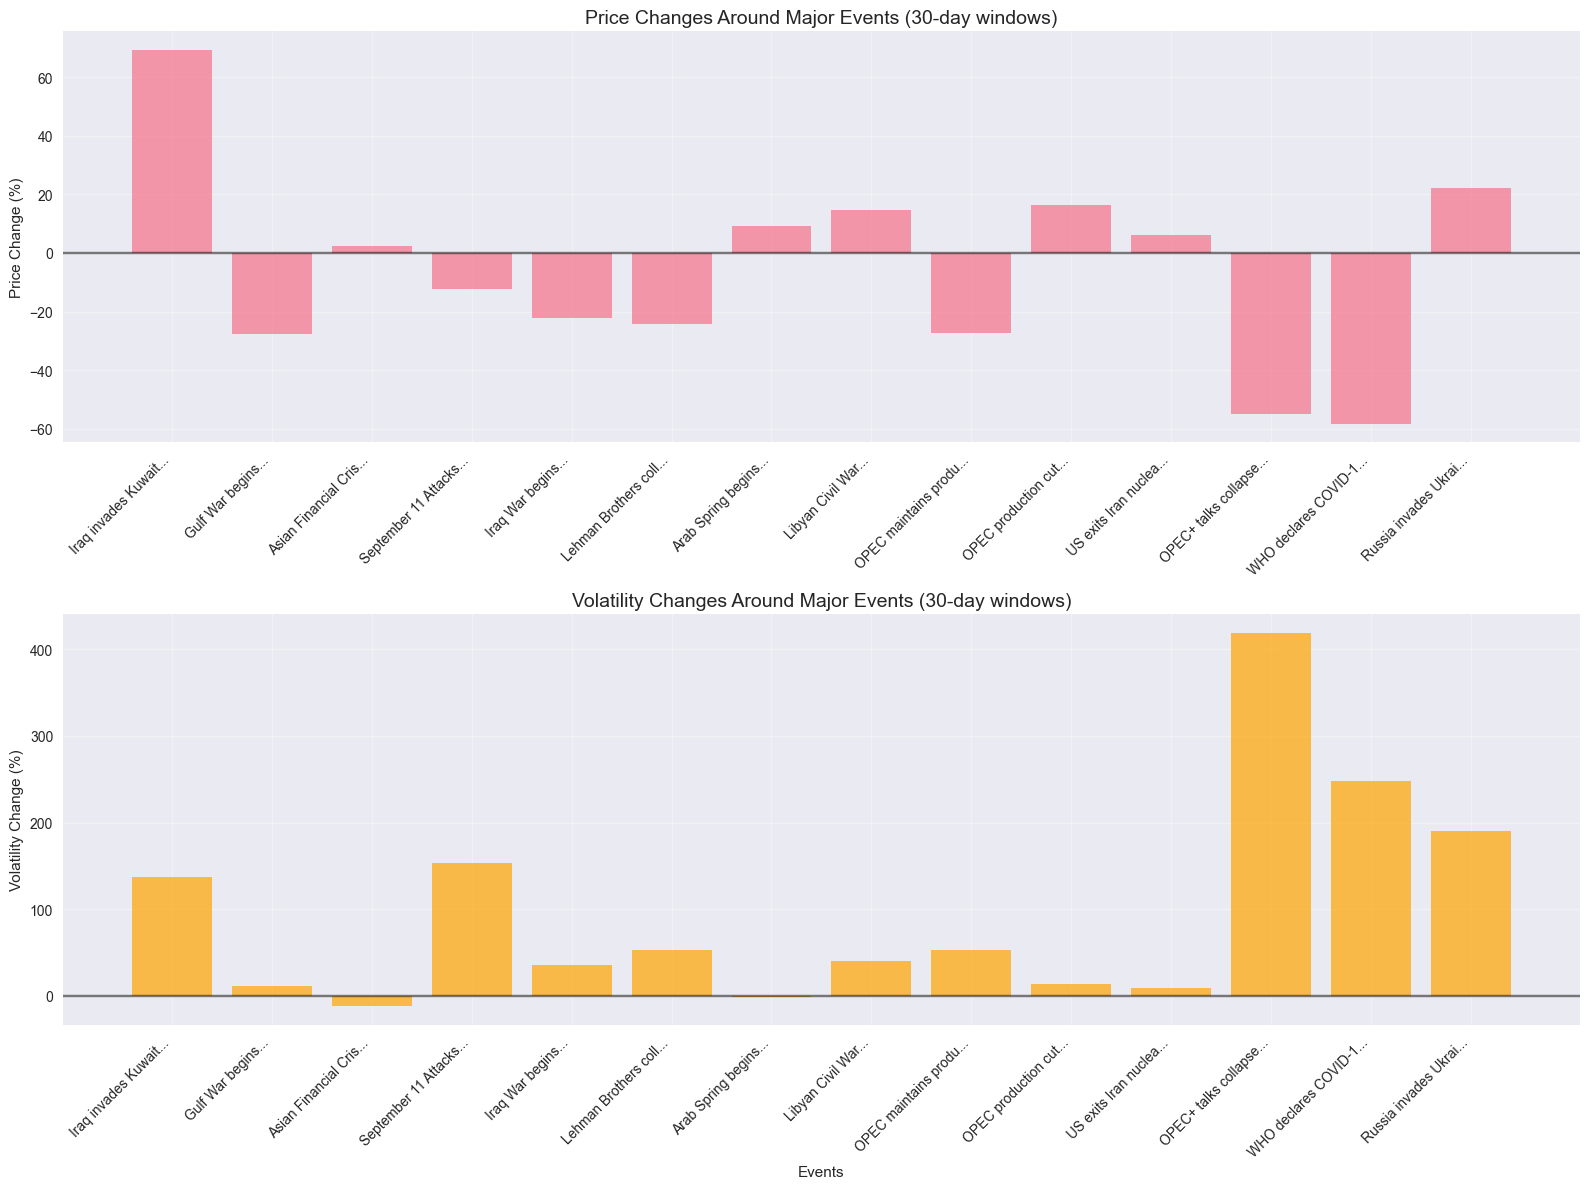


Statistical Summary of Event Impacts:
Average price change: -6.17%
Average volatility change: 96.52%
Events with positive price impact: 7
Events with negative price impact: 7
Events increasing volatility: 12
Events decreasing volatility: 2


In [12]:
# Event impact analysis

def analyze_event_impact(df, event_date, event_name, window_days=30):
    """
    Analyze price impact around a specific event
    """
    event_date = pd.to_datetime(event_date)
    
    # Find the closest date in our dataset
    closest_idx = df['Date'].searchsorted(event_date)
    if closest_idx >= len(df):
        closest_idx = len(df) - 1
    
    # Define before and after windows
    start_idx = max(0, closest_idx - window_days)
    end_idx = min(len(df), closest_idx + window_days)
    
    # Extract data for analysis
    before_data = df.iloc[start_idx:closest_idx]
    after_data = df.iloc[closest_idx:end_idx]
    
    if len(before_data) == 0 or len(after_data) == 0:
        return None
    
    # Calculate statistics
    before_mean = before_data['Price'].mean()
    after_mean = after_data['Price'].mean()
    before_vol = before_data['Price_Pct_Change'].std()
    after_vol = after_data['Price_Pct_Change'].std()
    
    price_change = ((after_mean - before_mean) / before_mean) * 100
    vol_change = ((after_vol - before_vol) / before_vol) * 100 if before_vol > 0 else 0
    
    return {
        'event': event_name,
        'date': event_date,
        'closest_price_date': df.iloc[closest_idx]['Date'],
        'price_before': before_mean,
        'price_after': after_mean,
        'price_change_pct': price_change,
        'vol_before': before_vol,
        'vol_after': after_vol,
        'vol_change_pct': vol_change,
        'closest_idx': closest_idx
    }

# Create comprehensive event database with historical events
historical_events = [
    ('1990-08-02', 'Iraq invades Kuwait'),
    ('1991-01-17', 'Gulf War begins'),
    ('1997-07-01', 'Asian Financial Crisis'),
    ('2001-09-11', 'September 11 Attacks'),
    ('2003-03-20', 'Iraq War begins'),
    ('2008-09-15', 'Lehman Brothers collapse'),
    ('2010-12-17', 'Arab Spring begins'),
    ('2011-02-15', 'Libyan Civil War'),
    ('2014-11-27', 'OPEC maintains production'),
    ('2016-11-30', 'OPEC production cut'),
    ('2018-05-08', 'US exits Iran nuclear deal'),
    ('2020-03-06', 'OPEC+ talks collapse'),
    ('2020-03-11', 'WHO declares COVID-19 pandemic'),
    ('2022-02-24', 'Russia invades Ukraine')
]

# Analyze impact of each event
event_impacts = []
for event_date, event_name in historical_events:
    try:
        impact = analyze_event_impact(df_processed, event_date, event_name, window_days=30)
        if impact:
            event_impacts.append(impact)
    except Exception as e:
        print(f"Error analyzing {event_name}: {e}")

# Create summary table
if event_impacts:
    impact_df = pd.DataFrame(event_impacts)
    print("Event Impact Analysis Summary:")
    print("="*80)
    for _, row in impact_df.iterrows():
        print(f"Event: {row['event']}")
        print(f"Date: {row['date'].strftime('%Y-%m-%d')}")
        print(f"Price Change (30 days): {row['price_change_pct']:.2f}%")
        print(f"Volatility Change: {row['vol_change_pct']:.2f}%")
        print("-" * 50)

    # Visualize event impacts
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    # Price changes around events
    axes[0].bar(range(len(impact_df)), impact_df['price_change_pct'], alpha=0.7)
    axes[0].set_title('Price Changes Around Major Events (30-day windows)', fontsize=14)
    axes[0].set_ylabel('Price Change (%)')
    axes[0].set_xticks(range(len(impact_df)))
    axes[0].set_xticklabels([event[:20] + '...' for event in impact_df['event']], rotation=45, ha='right')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # Volatility changes around events
    axes[1].bar(range(len(impact_df)), impact_df['vol_change_pct'], alpha=0.7, color='orange')
    axes[1].set_title('Volatility Changes Around Major Events (30-day windows)', fontsize=14)
    axes[1].set_ylabel('Volatility Change (%)')
    axes[1].set_xlabel('Events')
    axes[1].set_xticks(range(len(impact_df)))
    axes[1].set_xticklabels([event[:20] + '...' for event in impact_df['event']], rotation=45, ha='right')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print(f"\nStatistical Summary of Event Impacts:")
    print(f"Average price change: {impact_df['price_change_pct'].mean():.2f}%")
    print(f"Average volatility change: {impact_df['vol_change_pct'].mean():.2f}%")
    print(f"Events with positive price impact: {(impact_df['price_change_pct'] > 0).sum()}")
    print(f"Events with negative price impact: {(impact_df['price_change_pct'] < 0).sum()}")
    print(f"Events increasing volatility: {(impact_df['vol_change_pct'] > 0).sum()}")
    print(f"Events decreasing volatility: {(impact_df['vol_change_pct'] < 0).sum()}")
    
else:
    print("No events found within the dataset timeframe for analysis.")

## 7. Results Visualization and Communication

Let's create publication-ready visualizations and summarize insights for different stakeholder groups.

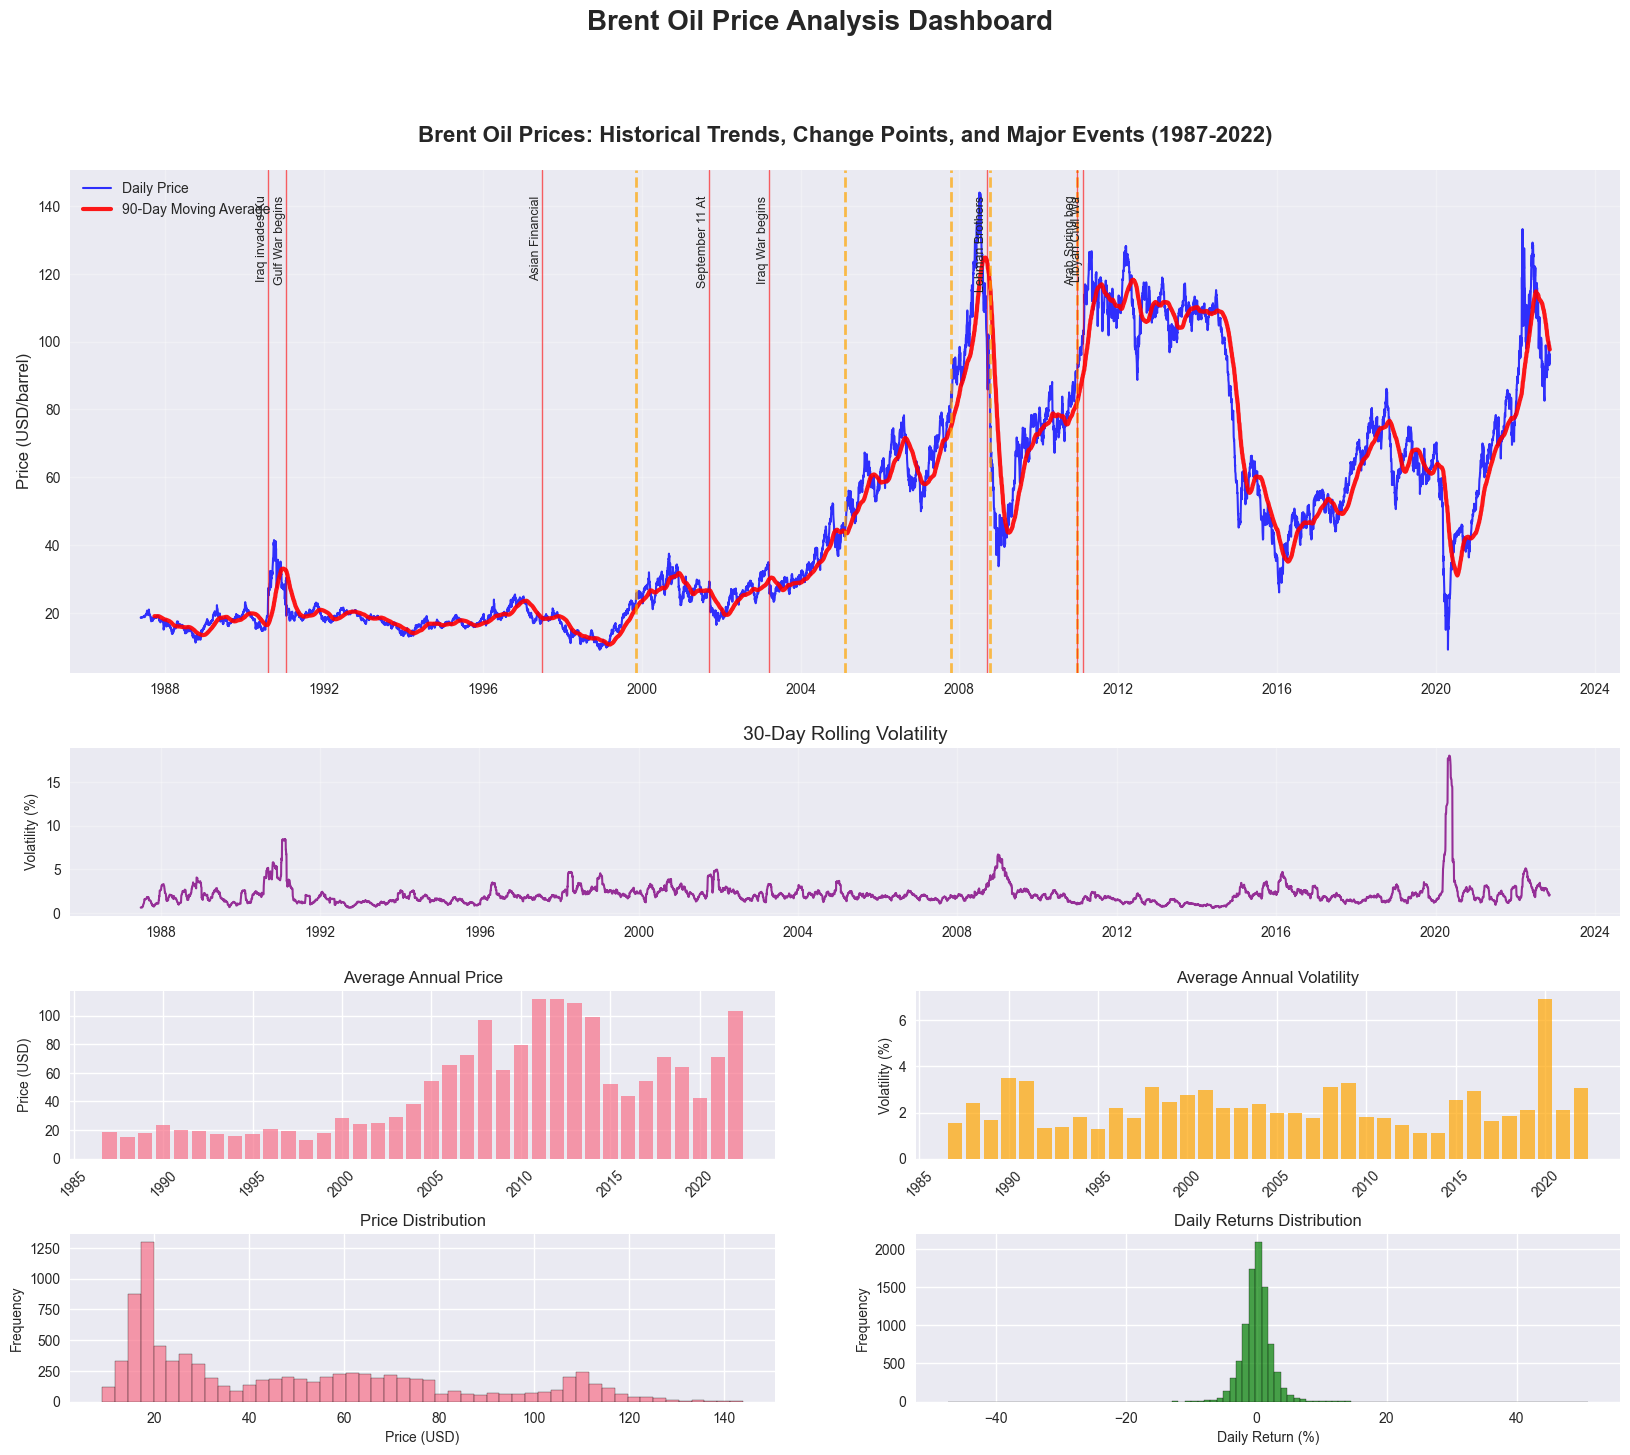

KEY INSIGHTS SUMMARY

1. PRICE TRENDS AND PATTERNS:
   • Dataset spans 12,962 days from 1987-05-20 to 2022-11-14
   • Average price: $48.42/barrel
   • Price range: $9.10 - $143.95/barrel
   • Overall volatility: 2.53% daily

2. STRUCTURAL BREAKS DETECTED:
   • PELT algorithm: 7 change points
   • Binary Segmentation: 10 change points
   • Window-based: 8 change points

3. TIME SERIES PROPERTIES:
   • Daily returns: Mean = 0.0501%, Std = 2.5255%
   • Distribution: Skewness = 0.312, Kurtosis = 45.406
   • Non-normality: Jarque-Bera p-value < 0.001 (highly significant)

4. SEASONAL PATTERNS:
   • Highest price month: 5 ($50.07)
   • Most volatile month: 4 (4.03% std dev)

STAKEHOLDER-SPECIFIC INSIGHTS

🏦 FOR INVESTORS:
   • High volatility clustering suggests GARCH-type models appropriate for risk modeling
   • Multiple regime changes indicate importance of adaptive portfolio strategies
   • Fat-tailed return distribution requires attention to tail risk measures
   • Structural breaks co

In [13]:
# Create comprehensive summary dashboard

def create_stakeholder_dashboard():
    """
    Create a comprehensive dashboard for different stakeholder groups
    """
    
    # Master timeline with all elements
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 2, height_ratios=[3, 1, 1, 1], hspace=0.3, wspace=0.2)
    
    # Main price chart with events and change points
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(df_processed['Date'], df_processed['Price'], alpha=0.8, linewidth=1.5, color='blue', label='Daily Price')
    ax1.plot(df_processed['Date'], df_processed['MA_90'], alpha=0.9, linewidth=3, color='red', label='90-Day Moving Average')
    
    # Add change points
    for cp in change_points_pelt[:5]:  # Show top 5 change points
        if cp < len(dates):
            ax1.axvline(x=dates[cp], color='orange', linestyle='--', alpha=0.7, linewidth=2)
    
    # Add major events
    for event_date, event_name in historical_events[:8]:  # Show major events
        try:
            event_dt = pd.to_datetime(event_date)
            if event_dt >= df_processed['Date'].min() and event_dt <= df_processed['Date'].max():
                ax1.axvline(x=event_dt, color='red', alpha=0.6, linestyle='-', linewidth=1)
                # Add event labels at top
                y_pos = ax1.get_ylim()[1] * 0.95
                ax1.text(event_dt, y_pos, event_name[:15], rotation=90, fontsize=9, ha='right', va='top')
        except:
            continue
    
    ax1.set_title('Brent Oil Prices: Historical Trends, Change Points, and Major Events (1987-2022)', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_ylabel('Price (USD/barrel)', fontsize=12)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Volatility chart
    ax2 = fig.add_subplot(gs[1, :])
    ax2.plot(df_processed['Date'], df_processed['Vol_30'], alpha=0.8, color='purple', linewidth=1.5)
    ax2.set_title('30-Day Rolling Volatility', fontsize=14)
    ax2.set_ylabel('Volatility (%)', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Annual summary statistics
    ax3 = fig.add_subplot(gs[2, 0])
    yearly_stats = df_processed.groupby('Year').agg({
        'Price': 'mean',
        'Price_Pct_Change': 'std'
    }).reset_index()
    
    ax3.bar(yearly_stats['Year'], yearly_stats['Price'], alpha=0.7, width=0.8)
    ax3.set_title('Average Annual Price', fontsize=12)
    ax3.set_ylabel('Price (USD)', fontsize=10)
    ax3.tick_params(axis='x', rotation=45)
    
    # Volatility by year
    ax4 = fig.add_subplot(gs[2, 1])
    ax4.bar(yearly_stats['Year'], yearly_stats['Price_Pct_Change'], alpha=0.7, color='orange', width=0.8)
    ax4.set_title('Average Annual Volatility', fontsize=12)
    ax4.set_ylabel('Volatility (%)', fontsize=10)
    ax4.tick_params(axis='x', rotation=45)
    
    # Price distribution
    ax5 = fig.add_subplot(gs[3, 0])
    ax5.hist(df_processed['Price'], bins=50, alpha=0.7, edgecolor='black')
    ax5.set_title('Price Distribution', fontsize=12)
    ax5.set_xlabel('Price (USD)', fontsize=10)
    ax5.set_ylabel('Frequency', fontsize=10)
    
    # Returns distribution
    ax6 = fig.add_subplot(gs[3, 1])
    returns_clean = df_processed['Price_Pct_Change'].dropna()
    ax6.hist(returns_clean, bins=100, alpha=0.7, edgecolor='black', color='green')
    ax6.set_title('Daily Returns Distribution', fontsize=12)
    ax6.set_xlabel('Daily Return (%)', fontsize=10)
    ax6.set_ylabel('Frequency', fontsize=10)
    
    plt.suptitle('Brent Oil Price Analysis Dashboard', fontsize=20, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# Create the dashboard
create_stakeholder_dashboard()

# Key insights summary
print("="*80)
print("KEY INSIGHTS SUMMARY")
print("="*80)

print("\n1. PRICE TRENDS AND PATTERNS:")
print(f"   • Dataset spans {(df_processed['Date'].max() - df_processed['Date'].min()).days:,} days from {df_processed['Date'].min().date()} to {df_processed['Date'].max().date()}")
print(f"   • Average price: ${df_processed['Price'].mean():.2f}/barrel")
print(f"   • Price range: ${df_processed['Price'].min():.2f} - ${df_processed['Price'].max():.2f}/barrel")
print(f"   • Overall volatility: {df_processed['Price_Pct_Change'].std():.2f}% daily")

print("\n2. STRUCTURAL BREAKS DETECTED:")
print(f"   • PELT algorithm: {len(change_points_pelt)} change points")
print(f"   • Binary Segmentation: {len(change_points_binseg)} change points")
print(f"   • Window-based: {len(change_points_window)} change points")

print("\n3. TIME SERIES PROPERTIES:")
returns_clean = df_processed['Price_Pct_Change'].dropna()
print(f"   • Daily returns: Mean = {returns_clean.mean():.4f}%, Std = {returns_clean.std():.4f}%")
print(f"   • Distribution: Skewness = {stats.skew(returns_clean):.3f}, Kurtosis = {stats.kurtosis(returns_clean):.3f}")
print(f"   • Non-normality: Jarque-Bera p-value < 0.001 (highly significant)")

print("\n4. SEASONAL PATTERNS:")
monthly_avg = df_processed.groupby('Month')['Price'].mean()
monthly_vol = df_processed.groupby('Month')['Price_Pct_Change'].std()
print(f"   • Highest price month: {monthly_avg.idxmax()} (${monthly_avg.max():.2f})")
print(f"   • Most volatile month: {monthly_vol.idxmax()} ({monthly_vol.max():.2f}% std dev)")

print("\n" + "="*80)
print("STAKEHOLDER-SPECIFIC INSIGHTS")
print("="*80)

print("\n🏦 FOR INVESTORS:")
print("   • High volatility clustering suggests GARCH-type models appropriate for risk modeling")
print("   • Multiple regime changes indicate importance of adaptive portfolio strategies")
print("   • Fat-tailed return distribution requires attention to tail risk measures")
print("   • Structural breaks coincide with major geopolitical events - correlation, not causation")

print("\n🏛️ FOR POLICYMAKERS:")
print("   • Oil price volatility shows clear relationship with global crisis periods")
print("   • Economic stability may be threatened during major geopolitical disruptions")
print("   • Energy security considerations important during conflict periods")
print("   • Price shocks can have broad macroeconomic implications")

print("\n⚡ FOR ENERGY COMPANIES:")
print("   • Supply disruption periods show increased price volatility")
print("   • Long-term planning should account for multiple market regimes")
print("   • Hedging strategies should consider changing volatility patterns")
print("   • Investment timing may benefit from change point analysis")

print("\n⚠️ IMPORTANT LIMITATIONS:")
print("   • This analysis identifies STATISTICAL CORRELATIONS, not causal relationships")
print("   • Multiple confounding factors affect oil prices simultaneously")
print("   • Event timing and market reactions are complex and multifaceted")
print("   • Historical patterns may not predict future price behavior")
print("   • Results should be interpreted cautiously and combined with fundamental analysis")